<a href="https://colab.research.google.com/github/atomicsyed-99/CNN_Find_Glasses/blob/master/Glasses_MobileNet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random

In [2]:
tf.random.set_seed(123456)

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
data_dir= "/content/drive/MyDrive/Images/Images"

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 5172 files belonging to 2 classes.
Using 3621 files for training.


In [6]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 5172 files belonging to 2 classes.
Using 1551 files for validation.


In [7]:
class_names = train_dataset.class_names
print(class_names)

['glasses', 'no_glasses']


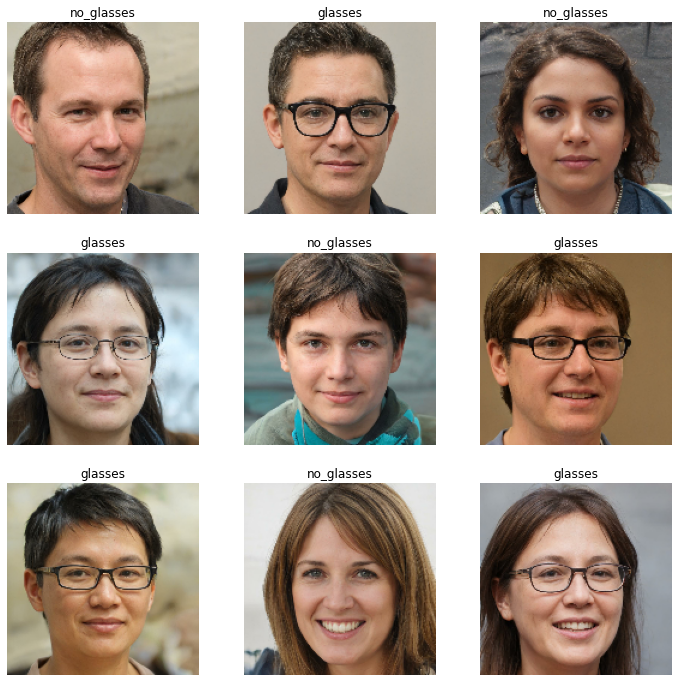

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of test batches:%d'%tf.data.experimental.cardinality(test_dataset))

Number of training batches: 114
Number of validation batches: 40
Number of test batches: 9
Number of test batches:9


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

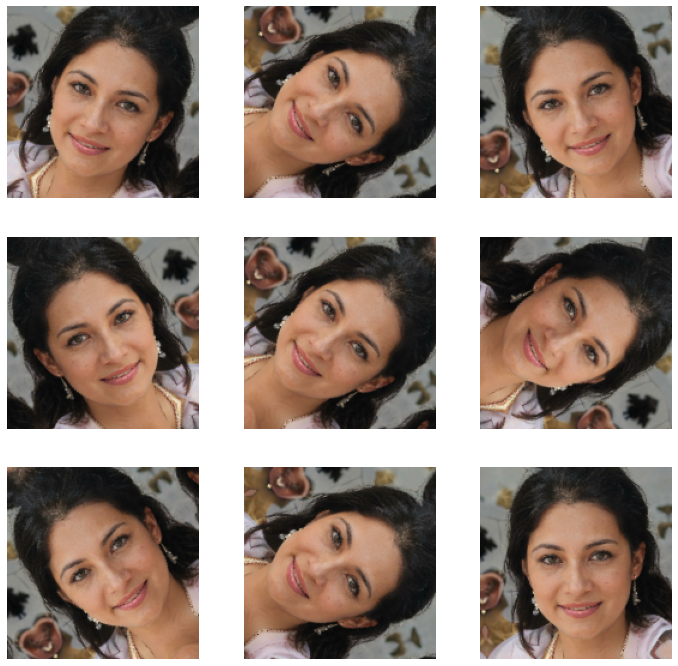

In [13]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 1s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

40/40 [==============================] - 539s 9s/step - loss: 0.6281 - accuracy: 0.6089


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.63
initial accuracy: 0.61


In [27]:
model_fit = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data=validation_dataset)



Epoch 1/10
114/114 [==============================] - 1143s 10s/step - loss: 0.6866 - accuracy: 0.5827 - val_loss: 0.5365 - val_accuracy: 0.6587
Epoch 2/10
114/114 [==============================] - 21s 178ms/step - loss: 0.5338 - accuracy: 0.7006 - val_loss: 0.4669 - val_accuracy: 0.7403
Epoch 3/10
114/114 [==============================] - 21s 179ms/step - loss: 0.4447 - accuracy: 0.7777 - val_loss: 0.4187 - val_accuracy: 0.7902
Epoch 4/10
114/114 [==============================] - 21s 180ms/step - loss: 0.3806 - accuracy: 0.8357 - val_loss: 0.3805 - val_accuracy: 0.8155
Epoch 5/10
114/114 [==============================] - 21s 179ms/step - loss: 0.3381 - accuracy: 0.8528 - val_loss: 0.3499 - val_accuracy: 0.8306
Epoch 6/10
114/114 [==============================] - 22s 182ms/step - loss: 0.3039 - accuracy: 0.8732 - val_loss: 0.3327 - val_accuracy: 0.8377
Epoch 7/10
114/114 [==============================] - 22s 181ms/step - loss: 0.2823 - accuracy: 0.8862 - val_loss: 0.3106 - val_ac

In [28]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

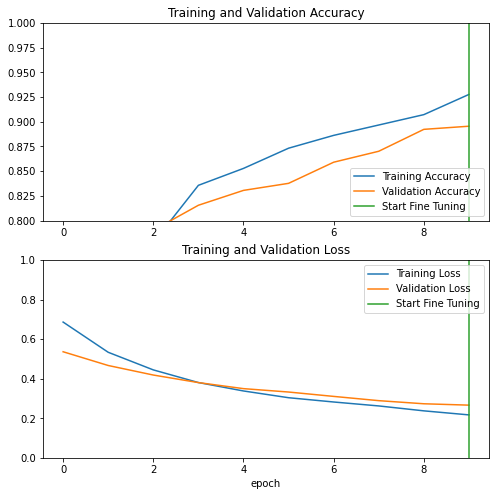

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

114/114 [==============================] - 15s 125ms/step - loss: 0.2501 - accuracy: 0.9050
Test accuracy : 0.9166666865348816
Train accuracy : 0.9049986004829407


In [31]:
base_model.trainable = True

In [32]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [34]:
len(model.trainable_variables)

56

In [35]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation_dataset)

Epoch 10/15
114/114 [==============================] - 28s 194ms/step - loss: 0.0718 - accuracy: 0.9754 - val_loss: 0.0288 - val_accuracy: 0.9937
Epoch 11/15
114/114 [==============================] - 23s 190ms/step - loss: 0.0282 - accuracy: 0.9906 - val_loss: 0.0086 - val_accuracy: 0.9992
Epoch 12/15
114/114 [==============================] - 22s 188ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0154 - val_accuracy: 0.9968
Epoch 13/15
114/114 [==============================] - 22s 186ms/step - loss: 0.0171 - accuracy: 0.9934 - val_loss: 0.0105 - val_accuracy: 0.9968
Epoch 14/15
114/114 [==============================] - 22s 185ms/step - loss: 0.0132 - accuracy: 0.9950 - val_loss: 0.0039 - val_accuracy: 0.9992
Epoch 15/15
114/114 [==============================] - 22s 187ms/step - loss: 0.0135 - accuracy: 0.9939 - val_loss: 0.0045 - val_accuracy: 0.9992


In [36]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

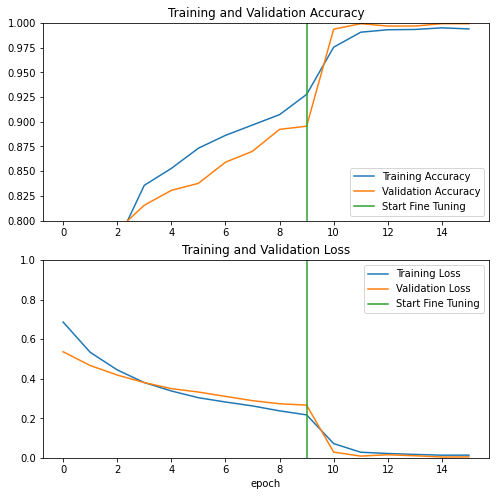

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
loss, accuracy2 = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)
print('Validation accuracy :', accuracy2)

40/40 [==============================] - 7s 109ms/step - loss: 0.0046 - accuracy: 0.9992
Test accuracy : 1.0
Train accuracy : 0.9986191391944885
Validation accuracy : 0.9992082118988037


Predictions:
 [0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1]
Labels:
 [0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1]


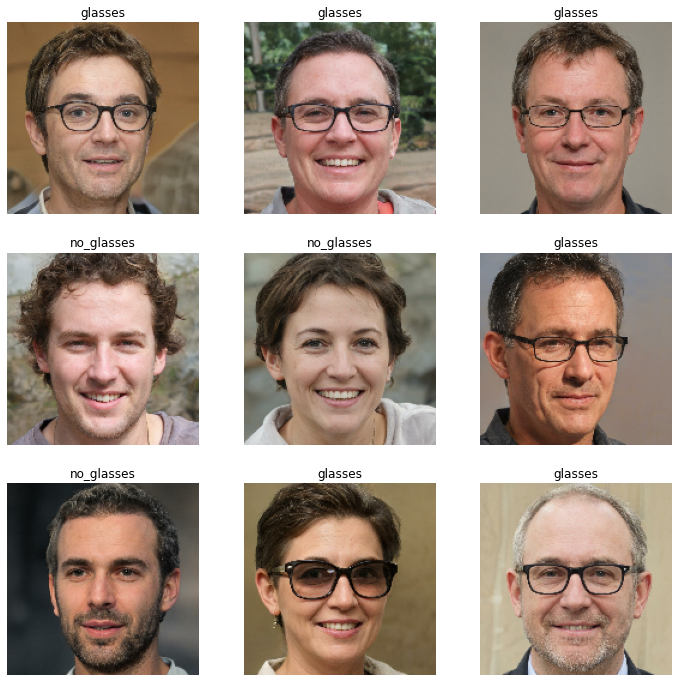

In [39]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")